# Machine Learning from the Ground Up

Today we will be creating a machine learning algorithm without relying on anything more than code we write ourselves and some basic calculus.

## Single-Variable Linear Least Squares

In the reading you saw the linear least squares approach to modeling the relationship between two variables.  In the reading, we saw the following model.

$y = wx + b + \epsilon$

Where $w$ is the slope of a line describing the relationship between x and y, $b$ is the y-intercept, and $\epsilon$ is an error term.  To make things even easier, we are going to consider an even more restrictive relationship between x and y.  Specifically, we will assume that the line describing the relationship between x and y goes through the origin (which implies $b = 0$).

$y = wx + \epsilon$

### Fitting a line to data

Suppose we are given a collection of independent variables $x_1, \ldots, x_n$ with each $x_i \in \mathbb{R}$ and corresponding dependent variables $y_1, \ldots, y_n$ with $y_i \in \mathbb{R}$.  You can think of the x's as height and y's as weight if that helps for concreteness.  We can write an error function that quantifies the sum of squared residuals (remember from the reading?).

$e(w) = \sum_{i=1}^n \left (wx_i - y_i\right)^2$

### An example dataset

Next, we will generate some data and examine the geometry of the function $e$.  In order to generate some data, we will use a built-in function scikit learn for generating synthetic datasets.  Synthetic datasets are ones where the relationship between inputs and outputs is known.  These datasets can be good for debugging machine learning algorithms.

True slope 69.9590207058


/home/pruvolo/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


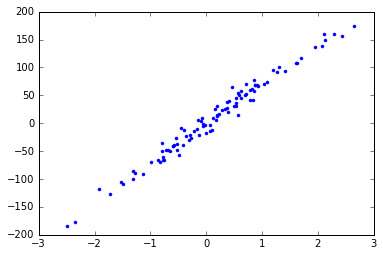

In [1]:
%matplotlib inline
from sklearn.datasets import make_regression
import numpy as np
import matplotlib.pyplot as plt

x, y, coef = make_regression(n_samples=100, n_features=1, noise=10, coef=True)
print "True slope", coef
plt.plot(x,y,'b.')
plt.show()

Next, plot $e(w)$.  What shape does the function have?

<function matplotlib.pyplot.show>

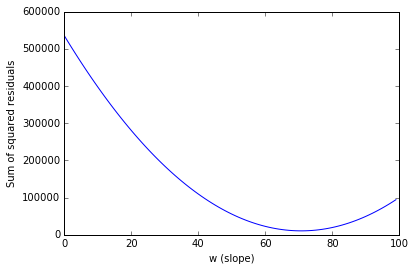

In [2]:
def error(w, x, y):
    """ Calculate the sum of squared residuals.  The data points
        x and y that are implicit inputs to the our function e
        passed as additional inputs to the Python function error
    """
    return np.sum([(y[i] - w*x[i])**2 for i in range(len(x))])

ws = np.arange(0,100,1)
plt.plot(ws, [error(w,x,y) for w in ws])
plt.xlabel("w (slope)")
plt.ylabel("Sum of squared residuals")
plt.show

### Gradient Descent

As discussed in ThinkStats Chapter 10, if we want to have a good model relating x and y, we should choose the slope, $w$, that minimizes the function $e(w)$.

In order to find the minimum of $e(w)$ we will use gradient descent.  The basic idea, is to calculate the slope of the function $e(w)$ at some initial guess $w_0$.  We then adjust our guess $w_0$ by moving it in the opposite direction of the slope of the function using this formula.

$w_1 = w_0 - \alpha \frac{d}{dw}e(w_0)$

Where $\alpha$ is a positive constant that specifies the step size.  To build intuition, determine how the second guess at the slope $w_1$ would change depending on the slope of $e$ evaluated at $w_0$.

This procedure can be iterated to construct a series of guesses of the the value of $w$.

$w_t = w_{t-1} - \alpha \frac{d}{dw}e(w_{t-1})$

Next, create a function called `error_grad` that computes the derivative of `error` with respect to $w$.

In [3]:
def error_grad(w, x, y):
    """ Computes the derivative of the error with respect to
        the slope w"""
    return np.sum([2*(y[i] - w*x[i])*(-x[i]) for i in range(len(x))])

w_0 = 2
estimate = error_grad(w_0, x, y)
estimate

-14397.392752906091

#### Sanity Check

Use the concept of [numerical differentiation](https://en.wikipedia.org/wiki/Numerical_differentiation) to make sure that your function `error_grad` is correct.

In [4]:
computed = (error(w_0+10**-6, x, y) - error(w_0, x, y))/10**-6
estimate - computed

-6.3190020227921195e-05

#### Implementation of Gradient Descent

Now that we are reasonably confident in our gradient computation, we can proceed to implement gradient descent.

70.7271098475


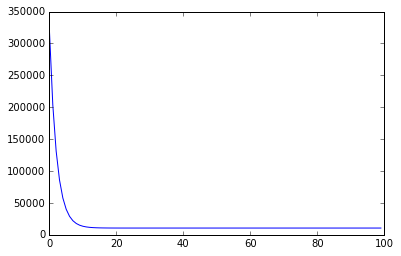

In [5]:
def gradient_descent(w, x, y, alpha, iters):
    errors = np.zeros((iters,1))
    for i in range(iters):
        w = w - alpha*error_grad(w, x, y)
        errors[i] = error(w, x, y)
    return w, errors

w_f, errors = gradient_descent(w_0, x, y, .001, 100)
print w_f
plt.plot(errors)

This basic approach to gradient descent is somewhat finicky.  Fortunately, we can do better by dynamically adjusting alpha depending on whether the error is increasing or decreasing.

70.7271098359


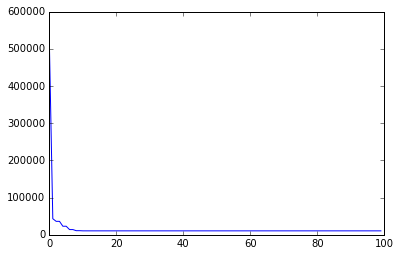

In [6]:
def gradient_descent(w, x, y, alpha, iters):
    errors = np.zeros((iters,1))
    last_error = error(w, x, y)
    for i in range(iters):
        w_proposed = w - alpha*error_grad(w, x, y)
        error_proposed = error(w_proposed, x, y)
        if error_proposed < last_error:
            last_error = error_proposed
            w = w_proposed
            alpha *= 1.5
        else:
            alpha *= 0.6
        errors[i] = last_error
            
    return w, errors

w_f, errors = gradient_descent(w_0, x, y, .01, 100)
print w_f
plt.plot(errors)

## Multivariate Linear Least Squares

All of the theory we just developed can be applied to the case where we have multiple independent variables that we'd like to use to model a single dependent variable.  In this case, we assume that the datapoints are now given as $x_1, \ldots, x_n$ with $x_i \in \mathbb{R}^d$.  As before we are also given corresponding targets $y_1, \ldots, y_n$ with $y_i \in \mathbb{R}$.  Now, the relationship between $y_i$ and $x_i$ is modeled as:

$y_i = \sum_{j=1}^d w_jx_i + \epsilon$

### Computing the Best Weights

In order to compute the best weights we have to define what we mean by best.  We will use the exact same notion of "error" that we used for the single variable case, that is the sum of squared errors.  To make this more concrete, let's load a dataset with multiple variables that we can use.

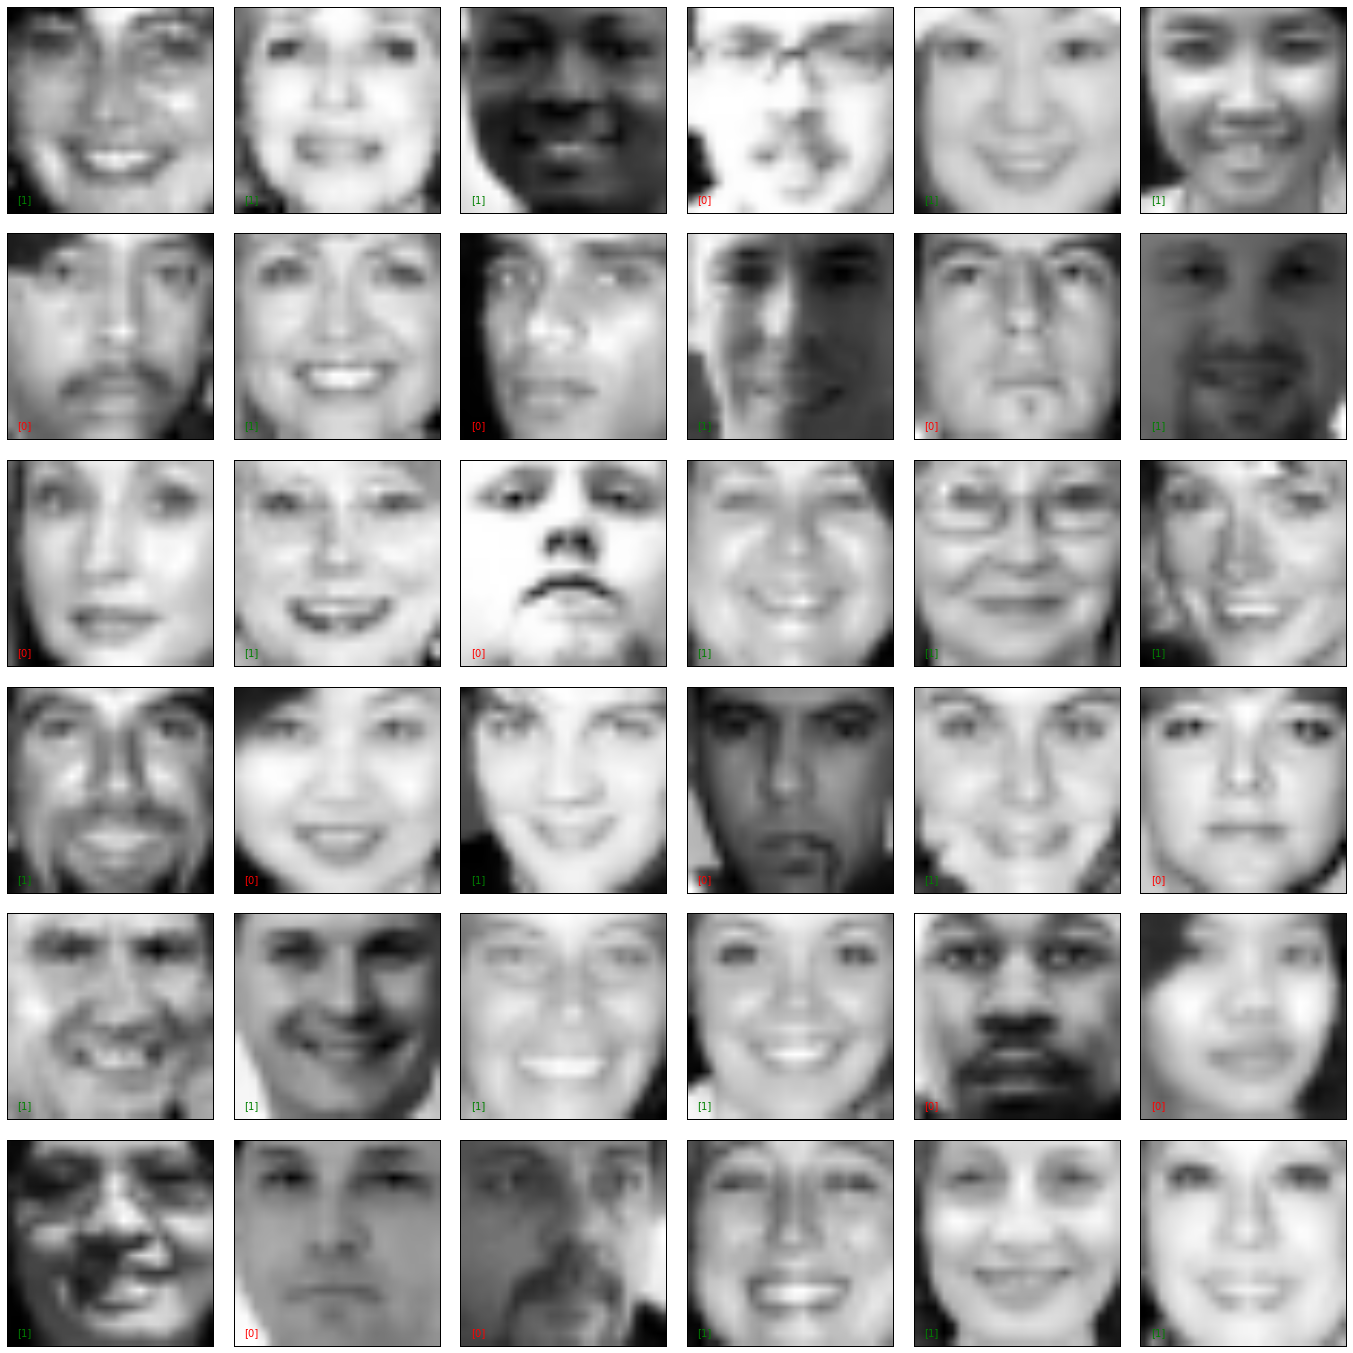

In [7]:
from load_smiles import load_smiles

def show_smiles(images, targets):
    """ Adapted from Jake Vanderplas' scikit learn tutorials. """
    fig, axes = plt.subplots(6, 6, figsize=(24, 24))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i,:].reshape((24,24)).T, cmap='gray')
        ax.text(0.05, 0.05, str(targets[i]),
                transform=ax.transAxes,
                color='green' if (targets[i]) else 'red')
        ax.set_xticks([])
        ax.set_yticks([])

data = load_smiles()
X, y = data.data, data.target
show_smiles(X, y)

### Computing the Error Function

Write some code to calculate the error for a set of weights.

In [8]:
def error_multi(w, X, y):
    predictions = X.dot(w)
    return np.sum((predictions - y)*(predictions - y))

w = np.zeros((576,1))
%timeit error_multi(w, data.data, data.target)

10 loops, best of 3: 30.9 ms per loop


### Computing the Gradient

The gradient of a function is a vector of all of the function's partial derivatives.

$\nabla f(x) = \begin{bmatrix} \frac{\partial}{\partial x_1}f(x) \\ \frac{\partial}{\partial x_2}f(x) \\ \vdots \\ \frac{\partial}{\partial x_d}f(x) \end{bmatrix}$

Next, we will write a function to compute the $i$th partial derivative of the function.

In [9]:
def partial_error_multi(w, X, y, j):
    partial = 0
    for i in range(X.shape[0]):
        prediction = X[i,:].T.dot(w)
        partial += 2*(prediction - y[i])*X[i,j]
    return partial

e_0 = np.zeros(w.shape)
e_0[0] = 10**-8

print "Computed partial 0", (error_multi(w+e_0, X, y) - error_multi(w, X, y))/e_0[0]
print "Analytical partial 0", partial_error_multi(w, X, y, 0)

e_1 = np.zeros(w.shape)
e_1[1] = 10**-6

print "Computed partial 1", (error_multi(w+e_1, X, y) - error_multi(w, X, y))/e_1[1]
print "Analytical partial 1", partial_error_multi(w, X, y, 1)

Computed partial 0 [-9330.32151806]
Analytical partial 0 [-9330.32135788]
Computed partial 1 [-9592.50055712]
Analytical partial 1 [-9592.50381156]


To speed things up, we make the observation that the predictions are independent of $j$, therefore we are wasting a lot of time computing them for reach $j$.

In [10]:
def grad_error_multi(w, X, y):
    grad = np.zeros(w.shape)
    res = X.dot(w) - y

    for i in range(X.shape[0]):
        grad += 2*res[i]*X[i,np.newaxis].T
    return grad

print grad_error_multi(w, X, y)[0:2]

[[-9330.32135788]
 [-9592.50381156]]


iter 0 error 2311.01142166
iter 100 error 764.070640133
iter 200 error 656.384581685
iter 300 error 589.84849695
iter 400 error 550.088279277
iter 500 error 524.357914746
iter 600 error 506.247298076
iter 700 error 493.177975681
iter 800 error 483.195214284
iter 900 error 475.933194532
iter 1000 error 470.41804297
iter 1100 error 465.247578607
iter 1200 error 460.878804772
iter 1300 error 456.790555472
iter 1400 error 453.510651264
iter 1500 error 450.741609584
iter 1600 error 447.977181029
iter 1700 error 445.299498228
iter 1800 error 442.881422237
iter 1900 error 440.790764221


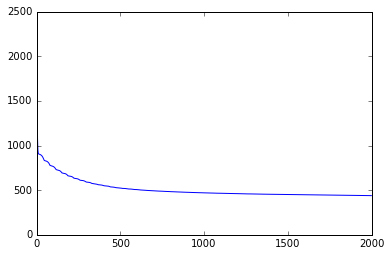

In [14]:
def gradient_descent_multi(w, x, y, alpha, iters):
    errors = np.zeros((iters,1))
    last_error = error_multi(w, x, y)
    all_ws = []

    for i in range(iters):
        all_ws.append(w)
        grad = grad_error_multi(w, x, y)
        w_proposed = w - alpha*grad
        error_proposed = error_multi(w_proposed, x, y)
        if error_proposed < last_error:
            last_error = error_proposed
            w = w_proposed
            alpha *= 1.1
        else:
            alpha *= 0.2
        if i % 100 == 0:
            print "iter", i, "error", last_error
        errors[i] = last_error
    return w, errors, all_ws

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.2)

w_f, errors, all_ws = gradient_descent_multi(w, X_train, y_train, 10**-7, 2000)
plt.plot(errors)

In [15]:
print np.mean((X_test.dot(w_f) > 0.5) == y_test)

0.873235075551


<function __main__.image_display>

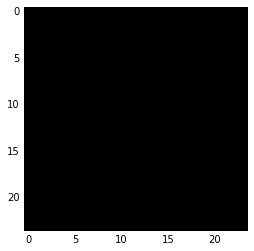

In [16]:
from IPython.html import widgets

def image_display(i):
    plt.imshow(all_ws[i].reshape((24,24)).T, cmap='gray')

step_slider = widgets.IntSlider(min=0, max=len(all_ws)-1, value=0)
widgets.interact(image_display, i=step_slider)